In [275]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json

In [276]:
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

## SCW ANALYSIS

Load the ScWs.

In [277]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

In [278]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg
crab_coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

In [279]:
angles = sun_coords.separation(crab_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))
    
print("Yearly Averages:", yearly_avg)
print("Monthly Averages:", monthly_avg)

Yearly Averages: [142.28613478815373, 106.35765153020502, 70.8803876788816, 38.252820677978185, 9.671421004120084, 19.227224516203876, 46.49379157875391, 74.60333863214184, 105.47156878492426, 142.66734311415345, 164.06952319819968, 116.43139343942262, 74.29712550441128, 42.80351759762254, 16.983759040764145, 7.323515297477644, 27.97459881896843, 49.279625740956185, 70.42696370153487, 91.54495818899403, 112.57840019656413, 130.00585024460335]
Monthly Averages: [76.0266407674818, 75.96667133164752, 75.92707403520043, 75.9725546086232, 75.86464765746229, 75.69092164913063, 75.52378598635912, 75.37070264444358, 72.24872861026289, 72.0424380893623, 72.02829034222552, 72.06157092740342]


/tmp/ipykernel_2225/3303049636.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


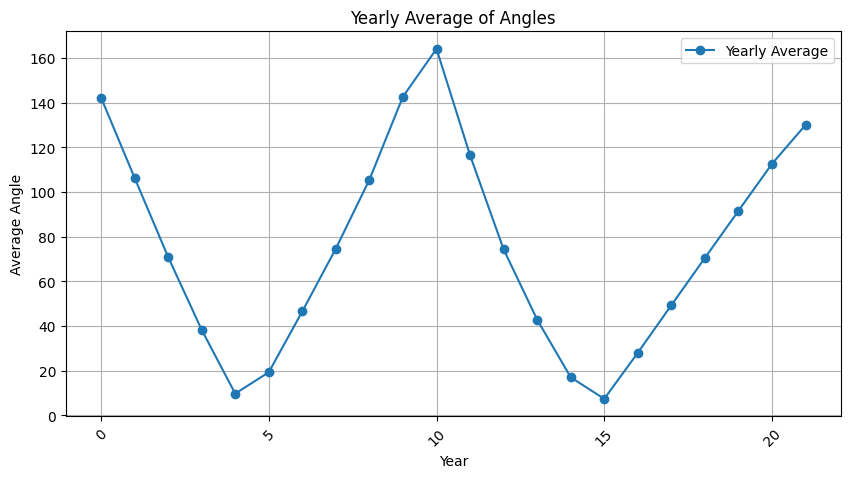

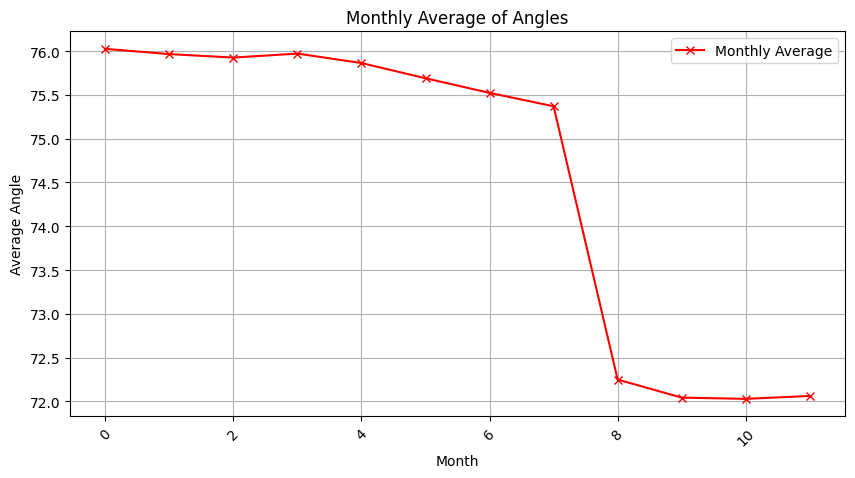

In [280]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

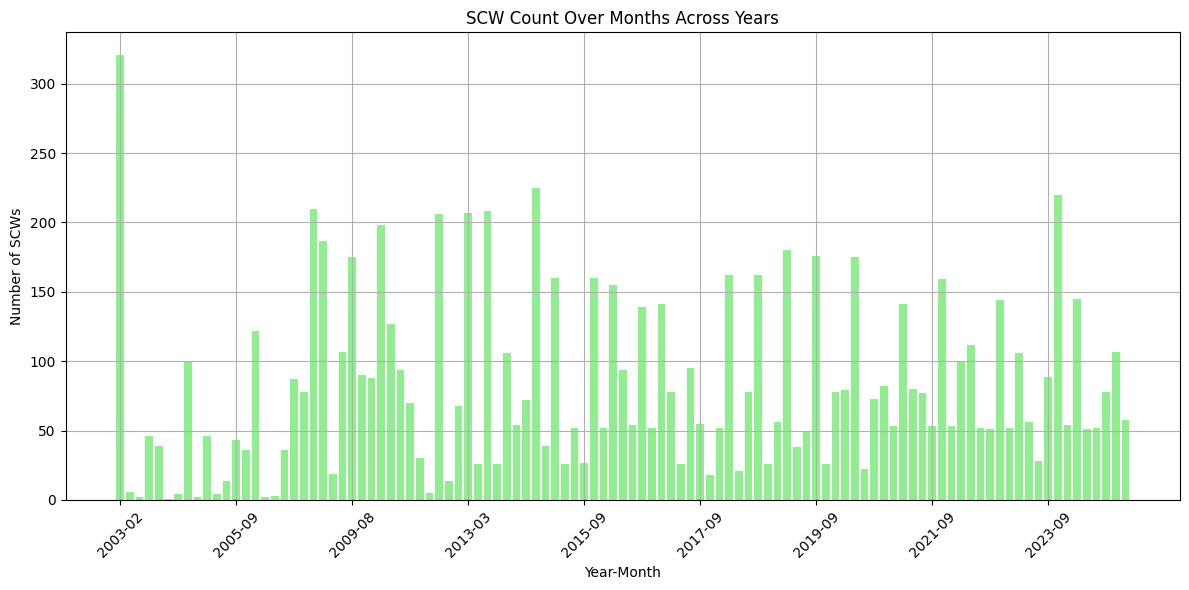

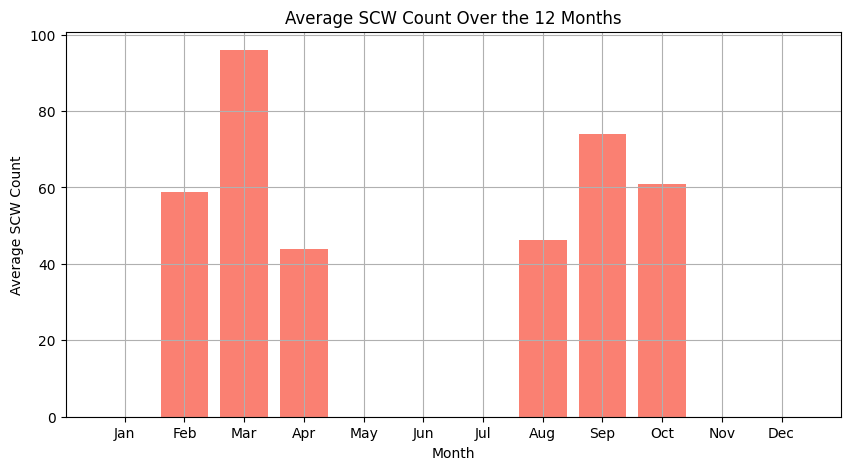

In [281]:
start_dates = [Time(t, format='mjd').datetime for t in start]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)


## QUERYING 

As we can see, Crab observations only happen twice per year in 3-month groups (Feb->Apr and Aug->Oct).
The idea now will be to get some longterm lightcurves over the years and see how the countrate evolves. Depending on the variability of the countrate, we will use it for flux conversion.

In [282]:
api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Crab"],
        [125.4826889038086],
        [ra],
        [dec],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

We use asynchronous querying. We aim to get one result per month, every year. Since the ScWs only happen in two 3-month intervals per year, this will mean 6 results every year for 22 years so 120 results total. 

To choose the ScW every month, we will take the shortest one for time reasons.

In [283]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

## IMAGES

In [284]:
disp_by_date = {}
data_by_date = {}

while True:
    image_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30",
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "detection_threshold": "5",
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_image",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
        }
        
        if scw_id not in disp_by_date:
            disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = disp_by_date[scw_id]
        
        data = data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                data_by_date[scw_id] = data

        image_results.append(data)

    n_complete = len([ year for year, _disp in disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_date)}")
    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pas

Is complete  True


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pas

RemoteException: RemoteException (line 99): Error when getting query products

In [285]:
image_results

Image analysis (extraction of count rates over time).

In [286]:
crab_countrates = []
crab_variances = []
obs_start_dates = []
obs_end_dates = []

for result in image_results:

    intensity_unit = result.mosaic_image_0_mosaic.get_data_unit(2)  
    header = result.mosaic_image_0_mosaic.get_data_unit(2).header
    intensity_data = intensity_unit.data 

    var_unit = result.mosaic_image_0_mosaic.get_data_unit(3)  
    var_data = var_unit.data

    wcs = WCS(header) 
    x, y = wcs.all_world2pix(ra, dec, 0)
    x_int, y_int = int(round(x.item())), int(round(y.item()))

    crab_countrates.append(intensity_data[y_int, x_int])
    crab_variances.append(var_data[y_int, x_int])
    obs_start_dates.append(header['DATE-OBS'])
    obs_end_dates.append(header['DATE-END'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58895.802222 from DATE-OBS.
Set MJD-END to 58895.811458 from DATE-END'. [astropy.wcs.wcs]


In [ ]:
output_filename = "crab_countrate_data.txt"

data = np.column_stack([obs_start_dates, obs_end_dates, crab_countrates, crab_variances])

header = "Obs Start Date, Obs End Date, Count Rate, Variance"

np.savetxt(output_filename, data, fmt="%s", delimiter=",", header=header, comments="")

print(f"Data saved to {output_filename}")

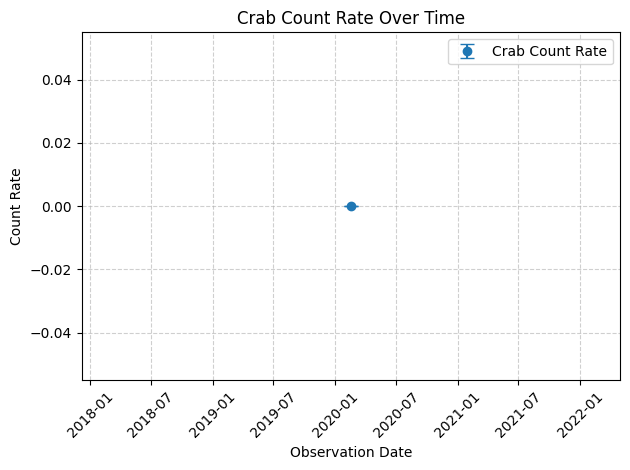

In [287]:
from datetime import datetime

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

crab_countrates = np.array(crab_countrates)
crab_variances = np.array(crab_variances)

errors = np.sqrt(crab_variances)

plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label="Crab Count Rate")

plt.xlabel("Observation Date")
plt.ylabel("Count Rate")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

## LIGHT CURVE

In [ ]:
lc_disp_by_date = {}
lc_data_by_date = {}

while True:
    lightcurve_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30", 
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "time_bin": duration_seconds, 
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_lc",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
            }
        
        if scw_id not in lc_disp_by_date:
            lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = lc_disp_by_date[scw_id]
        
        data = lc_data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                lc_data_by_date[scw_id] = data

        lightcurve_results.append(data)

    n_complete = len([ year for year, _disp in lc_disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(lc_disp_by_date)}")
    if n_complete == len(lc_disp_by_date):
        print("done!")
        break
    print("not done")

Light curve analysis.

## COMPARISON
Here we compare the count rate of the Crab over time between the two methods (using images or light curves).